In [16]:
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
%matplotlib inline
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, GRU, Flatten, LSTM, SimpleRNN
%run WordEmbeddings.ipynb

In [17]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=32):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(
            min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                       lookback,
                       data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j])
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
        
def alt_generator(data, lookback, delay, indices, batch_size=32):
    min_index = lookback
    max_index = len(data) - delay - 1
    current_batch_start = 0
    while True:
        if current_batch_start > len(indices): 
            current_batch_start = 0
        rows = indices[current_batch_start:min(current_batch_start+batch_size,max_index)]
        current_batch_start += batch_size
        samples = np.zeros((len(rows), lookback, data.shape[-1]))
        targets = np.zeros(len(rows),)
        for i, index in enumerate(rows): 
                if (index > min_index) and (index < max_index):
                    samples[i] = data[range(index - lookback,index)]
                    targets[i] = data[index + delay][-1]
        yield samples, targets
        
    
def add_rate_data(x_words,x_rates,indices):
    """Add time-series data of the rate/returns to a data point which
    containes some vectorized version of words. If the word-data has a datapoint from 
    a day not included in the rate/return-date, an average of the closest datapoints 
    in time are selected. 
    
    Parameters: 
    A numpy array x_words representing the words with shape n*d and a numpy array 
    x_rates of prices/rates with shape n. 
    
    Returns: 
    A numpy array of shape n*(d+1) 
    """
    start_date = x_rates.index[0]
    end_date = x_rates.index[-1]
    temp = np.zeros((x_words.shape[0], x_words.shape[1]+1))
    temp[:,:-1] = x_words
    n_interpol = 0
    for i, date in enumerate(indices): 
        if date not in x_rates: 
            n_interpol += 1
            prev_valid = date
            next_valid = date
            while prev_valid not in x_rates:
                prev_valid = prev_valid - timedelta(days=1)
                if prev_valid < start_date: 
                    prev_valid = start_date
                    break
            while next_valid not in x_rates: 
                next_valid = next_valid + timedelta(days=1)
                if next_valid > end_date: 
                    next_valid = end_date
                    break
            rate = (x_rates.loc[prev_valid] + x_rates.loc[next_valid]) / 2
            temp[i,-1] = rate
        else: 
            temp[i,-1] = x_rates.loc[date]
    print("{} interpolated values of {} total.".format(n_interpol, len(indices)))
    return temp

def plot_history(history,title="",train=True,val=True,log=True):
    if train: 
        plt.plot(history.history['loss'],label="Train")
    if val:
        plt.plot(history.history['val_loss'],label="Val")
    plt.legend()
    if log : plt.yscale('log')
    if not title == "" : plt.title(title)
    plt.show()

def naive_prediction_gen(gen, steps):
    mse = []
    for step in range(int(steps)):
        samples, targets = next(gen)
        preds = samples[:, -1, 1]
        mse.append(np.mean(np.square(preds - targets)))
    return np.mean(mse)

In [18]:
# Load and process the text data 
path = r"./Datasets/data/financial_headlines_20061020-20131119.pkl"
start_date = datetime(2006,10,20)
end_date = datetime(2013,1,1)
x, indices = process_text(path,method="tfidf",period=1,max_words=100)

Found 2582 days with 106494 news titles.
Concatinated to 2587 samples with an average of 41.1651 titles per sample.


In [19]:
# Load the financial data
financial_data = pd.read_pickle(r"./Datasets/data/stock_data.pkl")
oneyearrate = financial_data['1 YEAR']
threeyearrate = financial_data['3 YEAR']
SP = financial_data['S&P']
# Insert the 1-Year rate as a feature in the word-matrix
x = add_rate_data(x,oneyearrate,indices)
n,d = x.shape

740 interpolated values of 2587 total.


In [20]:
# Training for eps epochs
eps = 100

# Proportions of data usage
train_split = 0.6
val_split = 0.2
test_split = 0.2

# Shuffle the data to be used for train/val/test
indices = [i for i in range(n)]
np.random.shuffle(indices)
train_indices = indices[0:round(n*train_split)]
val_indices = indices[round(n*train_split):round(n*(train_split + val_split))]
test_indices = indices[round(n*(train_split + val_split)): n]

# Extract the financial data to be evaluated for ARIMA
train_fin = x[train_indices,-1]
val_fin = x[val_indices,-1]
test_fin = x[test_indices,-1]

lookback=12   # Lookback 12 weeks.
delay=12      # Predict 12 weeks ahead. 
batch_size=10
train_gen = alt_generator(data=x,
                      lookback=lookback,
                      delay=delay,
                      indices = train_indices,
                      batch_size=batch_size
)

val_gen = alt_generator(data=x,
                      lookback=lookback,
                      delay=delay,
                      indices = val_indices,
                      batch_size=batch_size
)

test_gen = alt_generator(data=x,
                      lookback=lookback,
                      delay=delay,
                      indices = test_indices,
                      batch_size=batch_size
)

val_steps = (val_split * n) // batch_size

test_steps = (test_split * n) // batch_size


In [21]:
# Create a simple feed-forward model (no recurrent layers)
m_ff = Sequential()
m_ff.add(Flatten(input_shape=(lookback,x.shape[-1])))
m_ff.add(Dense(32,activation='relu'))
m_ff.add(Dense(1))
m_ff.add(Activation('linear'))

m_ff.compile(loss='MSE',optimizer='adam')
m_ff.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1212)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                38816     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 38,849
Trainable params: 38,849
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Create a simple RNN model
m_rnn = Sequential()
m_rnn.add(SimpleRNN(32, return_sequences=True,input_shape=(None, x.shape[-1])))
m_rnn.add(SimpleRNN(32))
m_rnn.add(Dense(1))
m_rnn.compile(optimizer='adam',loss='mse')

m_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 32)          4288      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Create an RNN-model with GRU
m_gru = Sequential() 
m_gru.add(GRU(32,
              dropout=0.2,
              recurrent_dropout=0.2,
              return_sequences=True,
              input_shape=(None, x.shape[-1])))
m_gru.add(GRU(32,
             dropout=0.2,
             recurrent_dropout=0.2))
m_gru.add(Dense(1))

m_gru.compile(optimizer='adam', loss='mse')
m_gru.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 32)          12960     
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                6336      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 19,329
Trainable params: 19,329
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Create an RNN-model with LSTM
m_lstm = Sequential() 
m_lstm.add(LSTM(32,
                dropout=0.2,
                recurrent_dropout=0.2,
                return_sequences=True,
                input_shape=(None, x.shape[-1])))
m_lstm.add(LSTM(32,
                dropout=0.2,
                recurrent_dropout=0.2))
m_lstm.add(Dense(1))
m_lstm.compile(optimizer='adam', loss='mse')
m_lstm.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 32)          17152     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 25,505
Trainable params: 25,505
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Fit feed-forward model 
ff_history = m_ff.fit_generator(train_gen,
                               steps_per_epoch=10,
                               epochs=eps,
                               validation_data=val_gen,
                               validation_steps=val_steps)

Epoch 1/100
10/10 [==============================] - 1s 52ms/step - loss: 2.9125 - val_loss: 1.0892
Epoch 2/100
10/10 [==============================] - 0s 47ms/step - loss: 0.7798 - val_loss: 0.5260
Epoch 3/100
10/10 [==============================] - 0s 45ms/step - loss: 0.5636 - val_loss: 0.2998
Epoch 4/100
10/10 [==============================] - 0s 50ms/step - loss: 0.3770 - val_loss: 0.3828
Epoch 5/100
10/10 [==============================] - 0s 46ms/step - loss: 0.3150 - val_loss: 0.2425
Epoch 6/100
10/10 [==============================] - 0s 45ms/step - loss: 0.2058 - val_loss: 0.2786
Epoch 7/100
10/10 [==============================] - 0s 47ms/step - loss: 0.2211 - val_loss: 0.2661
Epoch 8/100
10/10 [==============================] - 0s 48ms/step - loss: 0.1661 - val_loss: 0.2077
Epoch 9/100
10/10 [==============================] - 0s 47ms/step - loss: 0.2273 - val_loss: 0.1914
Epoch 10/100
10/10 [==============================] - 0s 47ms/step - loss: 0.1197 - val_loss: 0.1621

10/10 [==============================] - 0s 49ms/step - loss: 0.0267 - val_loss: 0.0810
Epoch 83/100
10/10 [==============================] - 1s 56ms/step - loss: 0.0181 - val_loss: 0.0795
Epoch 84/100
10/10 [==============================] - 1s 54ms/step - loss: 0.0408 - val_loss: 0.1099
Epoch 85/100
10/10 [==============================] - 1s 50ms/step - loss: 0.0818 - val_loss: 0.0741
Epoch 86/100
10/10 [==============================] - 1s 60ms/step - loss: 0.0726 - val_loss: 0.2164
Epoch 87/100
10/10 [==============================] - 1s 70ms/step - loss: 0.0522 - val_loss: 0.2436
Epoch 88/100
10/10 [==============================] - 1s 51ms/step - loss: 0.0437 - val_loss: 0.0736
Epoch 89/100
10/10 [==============================] - 1s 59ms/step - loss: 0.0564 - val_loss: 0.0640
Epoch 90/100
10/10 [==============================] - 0s 50ms/step - loss: 0.0507 - val_loss: 0.0612
Epoch 91/100
10/10 [==============================] - 1s 52ms/step - loss: 0.0522 - val_loss: 0.1081
Epo

In [11]:
# Fit GRU-model  
gru_history = m_gru.fit_generator(train_gen,
                                 steps_per_epoch=10,
                                 epochs=eps,
                                 validation_data=val_gen,
                                 validation_steps=val_steps)


Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 5.5769 - val_loss: 2.1990
Epoch 2/100
10/10 [==============================] - 14s 1s/step - loss: 3.1414 - val_loss: 2.0337
Epoch 3/100
10/10 [==============================] - 14s 1s/step - loss: 2.9438 - val_loss: 1.7110
Epoch 4/100
10/10 [==============================] - 14s 1s/step - loss: 1.8611 - val_loss: 1.3725
Epoch 5/100
10/10 [==============================] - 15s 1s/step - loss: 1.0485 - val_loss: 1.2331
Epoch 6/100
10/10 [==============================] - 14s 1s/step - loss: 1.4423 - val_loss: 1.0859
Epoch 7/100
10/10 [==============================] - 14s 1s/step - loss: 1.3714 - val_loss: 0.9732
Epoch 8/100
10/10 [==============================] - 14s 1s/step - loss: 0.9253 - val_loss: 0.8744
Epoch 9/100
10/10 [==============================] - 15s 1s/step - loss: 0.9844 - val_loss: 0.9127
Epoch 10/100
10/10 [==============================] - 14s 1s/step - loss: 0.8334 - val_loss: 0.8566
Epoch 11/

10/10 [==============================] - 15s 1s/step - loss: 0.4000 - val_loss: 0.2868
Epoch 84/100
10/10 [==============================] - 14s 1s/step - loss: 0.3013 - val_loss: 0.2523
Epoch 85/100
10/10 [==============================] - 17s 2s/step - loss: 0.2507 - val_loss: 0.2262
Epoch 86/100
10/10 [==============================] - 20s 2s/step - loss: 0.3016 - val_loss: 0.2313
Epoch 87/100
10/10 [==============================] - 19s 2s/step - loss: 0.1620 - val_loss: 0.2299
Epoch 88/100
10/10 [==============================] - 19s 2s/step - loss: 0.2928 - val_loss: 0.2209
Epoch 89/100
10/10 [==============================] - 15s 2s/step - loss: 0.2699 - val_loss: 0.2296
Epoch 90/100
10/10 [==============================] - 16s 2s/step - loss: 0.2258 - val_loss: 0.2309
Epoch 91/100
10/10 [==============================] - 14s 1s/step - loss: 0.2908 - val_loss: 0.2560
Epoch 92/100
10/10 [==============================] - 14s 1s/step - loss: 0.2156 - val_loss: 0.3541
Epoch 93/100


In [12]:
rnn_history = m_rnn.fit_generator(train_gen,
                                 steps_per_epoch=10,
                                 epochs=eps,
                                 validation_data=val_gen,
                                 validation_steps=val_steps)

Epoch 1/100
10/10 [==============================] - 4s 393ms/step - loss: 2.8341 - val_loss: 2.3525
Epoch 2/100
10/10 [==============================] - 4s 365ms/step - loss: 2.0167 - val_loss: 2.0327
Epoch 3/100
10/10 [==============================] - 4s 365ms/step - loss: 1.9109 - val_loss: 1.5829
Epoch 4/100
10/10 [==============================] - 4s 367ms/step - loss: 1.6573 - val_loss: 1.1582
Epoch 5/100
10/10 [==============================] - 4s 353ms/step - loss: 1.0371 - val_loss: 0.9068
Epoch 6/100
10/10 [==============================] - 4s 355ms/step - loss: 0.6413 - val_loss: 0.7231
Epoch 7/100
10/10 [==============================] - 5s 456ms/step - loss: 0.8443 - val_loss: 0.5755
Epoch 8/100
10/10 [==============================] - 5s 487ms/step - loss: 0.4362 - val_loss: 0.4631
Epoch 9/100
10/10 [==============================] - 7s 654ms/step - loss: 0.4576 - val_loss: 0.4312
Epoch 10/100
10/10 [==============================] - 6s 585ms/step - loss: 0.2376 - val_lo

In [13]:
lstm_history = m_lstm.fit_generator(train_gen,
                                   steps_per_epoch=10,
                                   epochs=eps,
                                   validation_data=val_gen,
                                   validation_steps=val_steps)

Epoch 1/100
10/10 [==============================] - 13s 1s/step - loss: 3.1406 - val_loss: 2.4021
Epoch 2/100
10/10 [==============================] - 14s 1s/step - loss: 2.2915 - val_loss: 1.7882
Epoch 3/100
10/10 [==============================] - 13s 1s/step - loss: 1.6290 - val_loss: 1.1779
Epoch 4/100
10/10 [==============================] - 12s 1s/step - loss: 2.0013 - val_loss: 0.9487
Epoch 5/100
10/10 [==============================] - 13s 1s/step - loss: 0.9937 - val_loss: 0.5775
Epoch 6/100
10/10 [==============================] - 13s 1s/step - loss: 1.1483 - val_loss: 0.6166
Epoch 7/100
10/10 [==============================] - 10s 1s/step - loss: 1.0813 - val_loss: 0.2903
Epoch 8/100
10/10 [==============================] - 10s 1s/step - loss: 0.9076 - val_loss: 0.4312
Epoch 9/100
10/10 [==============================] - 10s 1s/step - loss: 0.4007 - val_loss: 0.2535
Epoch 10/100
10/10 [==============================] - 10s 1s/step - loss: 0.4093 - val_loss: 0.2253
Epoch 11/

Epoch 82/100
10/10 [==============================] - 10s 995ms/step - loss: 0.3138 - val_loss: 0.1037
Epoch 83/100
10/10 [==============================] - 9s 904ms/step - loss: 0.1975 - val_loss: 0.0535
Epoch 84/100
10/10 [==============================] - 9s 922ms/step - loss: 0.1948 - val_loss: 0.0571
Epoch 85/100
10/10 [==============================] - 9s 898ms/step - loss: 0.1792 - val_loss: 0.0619
Epoch 86/100
10/10 [==============================] - 9s 910ms/step - loss: 0.1027 - val_loss: 0.0796
Epoch 87/100
10/10 [==============================] - 9s 943ms/step - loss: 0.0760 - val_loss: 0.0517
Epoch 88/100
10/10 [==============================] - 9s 907ms/step - loss: 0.1472 - val_loss: 0.0573
Epoch 89/100
10/10 [==============================] - 9s 898ms/step - loss: 0.1176 - val_loss: 0.0485
Epoch 90/100
10/10 [==============================] - 9s 894ms/step - loss: 0.1459 - val_loss: 0.0451
Epoch 91/100
10/10 [==============================] - 9s 900ms/step - loss: 0.102

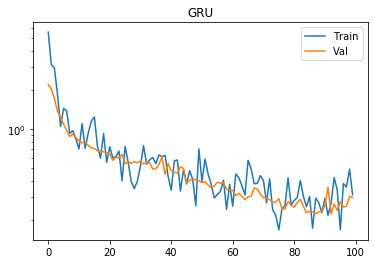

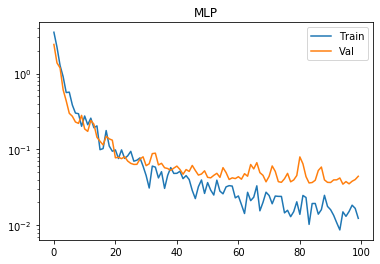

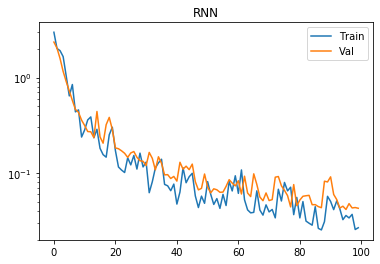

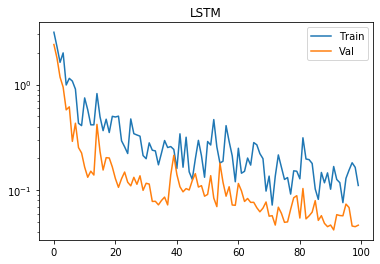

In [14]:
plot_history(gru_history,log=True,title="GRU")
plot_history(ff_history,log=True, title="MLP")
plot_history(rnn_history,log=True,title="RNN")
plot_history(lstm_history,log=True,title="LSTM")


In [15]:
# Evaluate the results on the test data. 
# Also evaluate the MSE of a naive approach which just predicts  the 
# rate in 3 months as the rate today. 
ff_eval = m_ff.evaluate_generator(test_gen, test_steps)
rnn_eval = m_rnn.evaluate_generator(test_gen, test_steps)
lstm_eval = m_lstm.evaluate_generator(test_gen, test_steps)
gru_eval = m_gru.evaluate_generator(test_gen, test_steps)

naive_eval = naive_prediction_gen(test_gen, test_steps)
pd.DataFrame({'MLP': ff_eval, 'SimpleRNN': rnn_eval, 'LSTM': lstm_eval, 'GRU': gru_eval, 'Naive': naive_eval}, index=['Test MSE'])

,MLP,SimpleRNN,LSTM,GRU,Naive
Test MSE,0.048019,0.046663,0.067411,0.333741,5.836652


In [38]:
# Save the models. 
now = datetime.now().strftime("%m_%d")
m_ff.save("Models\m_ff_{}.h5".format(now))
m_gru.save("Models\m_gru_{}.h5".format(now))
m_rnn.save("Models\m_rnn_{}.h5".format(now))
m_lstm.save("Models\m_lstm_{}.h5".format(now))

In [39]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

plot_model(m_ff)
#SVG(model_to_dot(m_ff).create(prog='dot', format='svg'))

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
